Many objects are saved in the ../tmp/ folder (e.g., model, endoR bootstraps, ...). Import them instead of running everything to save time ;) 

# Libraries

In [1]:
library(tidyverse)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(randomForest)
library(qs)
library(e1071)
library(RRF)
library(parallel)
library(igraph)
library(ggraph)
library(inTrees)
library(ggpubr)
library(clustermq)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomFore

In [2]:
library(clustermq)
options(clustermq.scheduler = "sge", clustermq.template = "~/.clustermq.tmpl")

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] endoR_0.1.0         clustermq_0.8.95.1  ggpubr_0.4.0       
 [4] inTrees_1.3         ggraph_2.0.4        igraph_1.2.6       
 [7] RRF_1.9.1           e1071_1.7-4         qs_0.23.4          
[10] randomForest_4.6-14 data.table_1.13.4   caret_6.0-86     

# Functions

In [4]:
# from common scripts 
file.sources <- list.files('../../Common_scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

In [5]:
wf <- function (ix, data, meta, target, families, genera, species, 
    gamma = 1, k = 0.5, ntree = 500) 
{
    set.seed(ix[1])
    res <- list()
    data <- mutate_if(data, is.character, as.factor)
    
    message("Feature selection")
    RF <- RRF(data[ix, ], flagReg = 0, as.factor(target[ix]))
    regterm <- data.frame(Feature = names(RF$importance[, "MeanDecreaseGini"]), 
        imp = RF$importance[, "MeanDecreaseGini"])
    regterm$imp_norm <- (regterm$imp - min(regterm$imp))/(max(regterm$imp) - 
        min(regterm$imp))
    regterm$imp_tax <- NA
    regterm$mb <- NA
    for (x in regterm$Feature) {
        tmp <- unique(c(families[[x]], genera[[x]], species[[x]]))
        ib <- which(regterm$Feature %in% tmp)
        if (length(ib) == 0) 
            next
        mb <- max(regterm$imp[ib])
        ib <- which(regterm$Feature == x)
        regterm$mb[ib] <- mb
        regterm$imp_tax[ib] <- regterm$imp[ib]/mb
    }
    regterm$imp_tax <- ifelse(is.na(regterm$imp_tax), regterm$imp_norm, 
        regterm$imp_tax)
    regterm$lambda <- (1 - gamma) + gamma * regterm$imp_norm^(1 - 
        k) * regterm$imp_tax^k
    GRRF <- RRF(data[ix, ], as.factor(target[ix]), flagReg = 1, 
        coefReg = regterm$lambda)
    
    message("Subset data")
    to_keep <- c(meta, colnames(data)[GRRF$feaSet])
    res$confirmed <- to_keep
    X_fs <- select(data, all_of(unique(to_keep)))
    
    message("RF")
    set.seed(ix[1])
    rf_fs <- randomForest(x = X_fs[ix,], y = target[ix], ntree = ntree)
    res$rf_model <- rf_fs
    if (length(ix) != nrow(data)) {
        pred <- predict(object = rf_fs, newdata = X_fs[-ix,])
        tmp <- confusionMatrix(data = pred, reference = target[-ix])
        res$rf_performance <- tmp$overall
    }
    return(res)
}

In [6]:
gammaTuning <- function(trainIx, data, meta, target, families, genera, species, params, ntree=500){
    res <- list()
    res <- lapply(trainIx, wf, data=data, meta=meta, target=target
                  , families = families, genera = genera, species = species
                  , gamma=params[['gamma']], k = params[['k']], ntree=ntree)
    names(res) <- rep(paste0(params['gamma'], '_', params['k']), length(res))
    return(res)
}

# Data

In [7]:
tax_names <- read.table('../data/taxonomy_table.txt', sep = '\t', header = TRUE)

In [8]:
head(tax_names, 3)

,k,p,c,o,f,g,s
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k_Bacteria,p_Firmicutes,c_Clostridia,o_Clostridiales,f_Lachnospiraceae,g,s_Eubacterium_rectale
2,k_Bacteria,p_Bacteroidetes,c_Bacteroidia,o_Bacteroidales,f_Odoribacteraceae,g_Odoribacter,s_Odoribacter_splanchnicus
3,k_Bacteria,p_Bacteroidetes,c_Bacteroidia,o_Bacteroidales,f_Bacteroidaceae,g_Bacteroides,s_Bacteroides_uniformis


In [9]:
tmp <- readRDS('../data/taxa_lists.RDS')
families <- tmp[[1]]
genera <- tmp[[2]]
species <- tmp[[3]]

In [10]:
families[1:3] %>% lapply(head)

$f_Lachnospiraceae
[1] "f_Lachnospiraceae"   "g"                   "g_Anaerostipes"     
[4] "g_Roseburia"         "g_Lachnoclostridium" "g_Blautia"          

$f_Odoribacteraceae
[1] "f_Odoribacteraceae" "g_Odoribacter"      "g_Butyricimonas"   

$f_Bacteroidaceae
[1] "f_Bacteroidaceae" "g_Bacteroides"

In [11]:
X <- readRDS('../data/X.RDS')
target <- readRDS('../data/target.RDS')

In [12]:
tmp <- dummyVars(~., data = X)
X <- predict(tmp, newdata = X) %>% as.data.frame %>% select(-Sexmale)

In [13]:
table(target)

target
Cirrhosis   Healthy 
       68        62 

In [14]:
mnames <- c('Sexfemale','Age','BMI','number_reads')

In [15]:
set.seed(0)
trainIx <- createDataPartition(y = target, times = 10, p = .7, list = TRUE)

# Train 

## CV

In [16]:
gammas <- seq(0,1, by = 0.1)
ks <- seq(0,1,0.1)

In [17]:
params<-as.list(data.frame(t(expand.grid(gammas, ks))))

In [18]:
params <- params %>% lapply(function(x){names(x)<-c('gamma', 'k');return(x)})
names(params) <- params %>% sapply(paste, collapse = '_')

In [19]:
tmpl <- list(conda = "r-ml", cores = 5, job_time = '00:59:00', job_mem = '5G')

In [20]:
res <- Q(gammaTuning
  , params = params
  , const = list('data'= X, 'meta' = mnames, 'target' = target, 'trainIx' = trainIx
                 , 'families' = families,'genera' = genera, 'species' = species, ntree = 500
                 )
  , export = list('wf' = wf)
  , n_jobs= length(params)
  , pkgs=c('caret', 'randomForest', 'dplyr', 'RRF')
  , log_worker=FALSE
  , template = tmpl
 )

Warning message in (function (...) :
“Common data is 3.5 Mb. Recommended limit is  (set by clustermq.data.warning option)”
Submitting 121 worker jobs (ID: cmq7546) ...

Running 121 calculations (9 objs/3.5 Mb common; 1 calls/chunk) ...


[--------------------------------------------------]   0% (1/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (2/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (3/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (4/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (5/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (6/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (7/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (8/121 wrk) eta:  ?s

[--------------------------------------------------]   0% (9/121 wrk) eta:  ?s

[-----------------------------------------


[=========>---------------------------------------]  21% (77/121 wrk) eta:  4m

[==========>--------------------------------------]  21% (77/121 wrk) eta:  3m

[==========>--------------------------------------]  22% (77/121 wrk) eta:  3m

[==========>--------------------------------------]  23% (77/121 wrk) eta:  3m

[===========>-------------------------------------]  24% (77/121 wrk) eta:  3m

[===========>-------------------------------------]  25% (77/121 wrk) eta:  3m

[============>------------------------------------]  26% (77/121 wrk) eta:  3m

[============>------------------------------------]  27% (77/121 wrk) eta:  3m

[=============>-----------------------------------]  28% (77/121 wrk) eta:  2m

[=============>-----------------------------------]  29% (77/121 wrk) eta:  2m

[==============>----------------------------------]  30% (77/121 wrk) eta:  2m

[==============>----------------------------------]  31% (77/121 wrk) eta:  2m

[===============>----------------------


[============================================>-----]  91% (21/47 wrk) eta:  9s

[============================================>-----]  91% (22/47 wrk) eta:  9s

[=============================================>----]  92% (22/47 wrk) eta:  8s

[=============================================>----]  93% (21/46 wrk) eta:  7s

[=============================================>----]  93% (21/45 wrk) eta:  7s

[=============================================>----]  93% (21/44 wrk) eta:  7s

[=============================================>----]  93% (22/44 wrk) eta:  7s

[=============================================>----]  93% (23/44 wrk) eta:  7s

[=============================================>----]  93% (23/43 wrk) eta:  7s

[=============================================>----]  93% (24/43 wrk) eta:  7s

[==============================================>---]  93% (23/42 wrk) eta:  6s

[==============================================>---]  94% (23/42 wrk) eta:  5s

[======================================

In [22]:
saveRDS(res, file = '../tmp/ta-gRRF.RDS')

## Results

In [23]:
res <- readRDS('../tmp/ta-gRRF.RDS')

In [24]:
all <- list()
for (i in 1:length(res)){
    all[[i]] <- as.data.frame(do.call(rbind, lapply(res[[i]], function(x) x$rf_performance)))
    all[[i]]$nconf <- sapply(res[[i]], function(x)length(x$confirmed))
    all[[i]]$gamma <- params[[i]]['gamma'] 
    all[[i]]$k <- params[[i]]['k']        
}

In [25]:
all <- do.call(rbind, all)

In [26]:
all %>% group_by(gamma, k) %>%
summarise_all(mean) %>%
arrange(-Kappa) %>% 
head(3)%>% 
select(Accuracy, Kappa, k, gamma, nconf)

Accuracy,Kappa,k,gamma,nconf
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8657895,0.7322431,1.0,0.9,68.7
0.8657895,0.7322056,0.0,0.1,33.8
0.8631579,0.7270019,0.6,0.1,37.2


In [27]:
all %>% group_by(gamma, k) %>%
summarise_all(sd) %>%
subset(k == 1 & gamma == 0.9) %>% 

select(Accuracy, Kappa, k, gamma, nconf)

Accuracy,Kappa,k,gamma,nconf
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0381352,0.07550325,1,0.9,10.65677


# Final

In [28]:
rf_final <- wf(ix = 1:nrow(X), data = X, meta = mnames, target = target
                 , families = families,genera = genera, species = species, ntree = 500
              , gamma=0.9, k = 1)

Feature selection

Subset data

RF



In [29]:
rf_final %>% summary

          Length Class        Mode     
confirmed 85     -none-       character
rf_model  18     randomForest list     

In [30]:
qsave(rf_final, '../tmp/ta-gRRF_final.qs')

In [128]:
#rf_final <- qread('../tmp/ta-gRRF_final.qs')

In [31]:
rf_final$rf_model #%>% summary


Call:
 randomForest(x = X_fs[ix, ], y = target[ix], ntree = ntree) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 9.23%
Confusion matrix:
          Cirrhosis Healthy class.error
Cirrhosis        60       8  0.11764706
Healthy           4      58  0.06451613

In [32]:
cat('RF accuracy = ', 100*round((rf_final$rf_model$confusion[1,1] + rf_final$rf_model$confusion[2,2])/sum(rf_final$rf_model$confusion), digits = 4))

RF accuracy =  90.64

In [33]:
gini <- data.frame(MeanDecreaseGini = rf_final$rf_model$importance[,1]
                   , Feature = names(rf_final$rf_model$importance[,1])) %>% arrange(-MeanDecreaseGini)
rownames(gini) <- NULL
gini$Feature <- factor(gini$Feature, levels = gini$Feature[order(-gini$MeanDecreaseGini)])

In [34]:
gini %>% head

,MeanDecreaseGini,Feature
,<dbl>,<fct>
1,6.637459,s_Megasphaera_micronuciformis
2,4.184697,f_Veillonellaceae
3,3.642787,s_Veillonella_parvula
4,2.768751,g_Leptotrichia
5,2.588696,g_Streptococcus
6,2.439022,f_Eggerthellaceae


In [35]:
X_fs <- X %>% select(unique(c(mnames, rf_final$confirmed)))

In [36]:
X_fs %>% dim

[1] 130  85

# endoR

In [37]:
colnames(X_fs) <- compatibleNames(colnames(X_fs)) 

In [38]:
preclu <- preCluster(model = rf_final$rf_model
                , model_type = 'rf'
                , discretize = TRUE, K = 3
                , times = 100, p = .75, ntree = 'all'
                , data = X_fs, target = target
                , seed = 1
                , in_parallel = TRUE, n_cores = 5)

Extract rules...

Discretise data

Discretise rules



In [39]:
table(target)

target
Cirrhosis   Healthy 
       68        62 

In [57]:
qsave(preclu, '../tmp/ta-gRRF_preclu.qs')

In [13]:
#preclu <- qread('../tmp/ta-gRRF_preclu.qs')

In [58]:
tmpl <- list(conda = "r-ml", cores = 10, job_time = '00:59:00', job_mem = '2G')

In [59]:
rules <- Q(model2DE_cluster
  , partition = preclu$partitions
  , export=list(data = preclu$data, target = as.character(target)
                , exec = preclu$exec, classPos = 'Cirrhosis'
                , prune = TRUE, maxDecay = 0.05, typeDecay = 2 
                , filter = TRUE
                , in_parallel = TRUE, n_cores = 10
               )
  , n_jobs= length(preclu$partitions)
  , pkgs=c('data.table', 'parallel', 'caret', 'stringr', 'scales', 'dplyr', 'inTrees', 'endoR')
  , log_worker=FALSE
  , template = tmpl
 )

Warning message in (function (...) :
“Common data is 7.2 Mb. Recommended limit is  (set by clustermq.data.warning option)”
Submitting 100 worker jobs (ID: cmq9902) ...

Running 100 calculations (10 objs/7.2 Mb common; 1 calls/chunk) ...


[--------------------------------------------------]   0% (1/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (2/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (3/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (4/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (5/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (6/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (7/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (8/100 wrk) eta:  ?s

[--------------------------------------------------]   0% (9/100 wrk) eta:  ?s

[----------------------------------------


[======================================>----------]  79% (22/100 wrk) eta: 45s

[=======================================>----------]  80% (21/99 wrk) eta: 43s

[=======================================>----------]  81% (20/98 wrk) eta: 42s

[========================================>---------]  82% (19/97 wrk) eta: 40s

[=========================================>--------]  83% (18/96 wrk) eta: 37s

[=========================================>--------]  84% (17/95 wrk) eta: 36s

[=========================================>--------]  84% (17/94 wrk) eta: 36s

[=========================================>--------]  84% (18/94 wrk) eta: 36s

[=========================================>--------]  85% (18/94 wrk) eta: 33s

[=========================================>--------]  85% (17/93 wrk) eta: 34s

[=========================================>--------]  85% (17/92 wrk) eta: 34s

[==========================================>-------]  86% (16/91 wrk) eta: 32s

[======================================

In [60]:
qsave(rules, '../tmp/ta-gRRF_bootstraps.qs')

In [14]:
#rules <- qread('../tmp/ta-gRRF_bootstraps.qs')

# Results

## Choose alpha

In [61]:
check_sampl <- evaluateAlpha(rules = rules, alphas = c(5, 10, 15, 20, 30, 50, 75), pi_thr = 0.7
                            , data = preclu$data, decision_ensembles = FALSE)

111.8087  rules per sub-sample selected. 4 decisions in >= 70 subsets.
158.1213  rules per sub-sample selected. 5 decisions in >= 70 subsets.
193.6583  rules per sub-sample selected. 7 decisions in >= 70 subsets.
223.6174  rules per sub-sample selected. 12 decisions in >= 70 subsets.
273.8742  rules per sub-sample selected. 18 decisions in >= 70 subsets.
353.5701  rules per sub-sample selected. 28 decisions in >= 70 subsets.
433.0331  rules per sub-sample selected. 47 decisions in >= 70 subsets.


In [62]:
al_plot <- ggplot(check_sampl, aes(y = n_samp, x = alpha))+
geom_hline(yintercept = nrow(preclu$data), color = "#00A08A", size = .5)+
geom_vline(xintercept = 30, color = 'darkgrey', linetype = 'longdash')+
geom_line()+
geom_point(aes(size = n_dec))+
theme_classic()+
ylim(c(0, NA))+

scale_size(breaks = c(10, 30))+

labs(x = expression(alpha*' error'), y = '# predicted samples'
     , size = '# decisions'
     , title = 'Effect of \u03b1')+ 
theme(axis.title = element_text(size = rel(1.2))
      , axis.text = element_text(size = rel(1))
      , legend.title = element_text(size = rel(1.2))
      , legend.text = element_text(size = rel(1.2))
      , legend.position = 'bottom'
     )

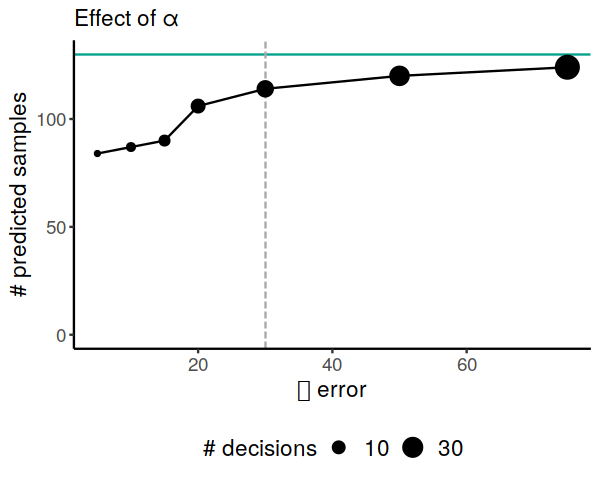

In [63]:
options(repr.plot.width=5, repr.plot.height=4)
al_plot

## stable decision ensemble

In [64]:
pc <- stabilitySelection(rules = rules, alpha_error = 30, pi_thr = .7)

273.8742  rules per sub-sample selected. 18 decisions in >= 70 subsets.


## some formatting for plots

In [66]:
pc$nodes$var %>% str_replace(pattern = '\\_{2}.*', replacement = '') %>%unique %>% length

[1] 23

In [67]:
pc$nodes$Feature <- pc$nodes$var

In [68]:
pc$edges$x <- pc$edges$x %>% str_replace(pattern = '(?<=s\\_[:upper:])[:lower:]+(?=\\_)', replacement = '') %>%
                str_replace(pattern = '^[:lower:]\\_', replacement = '')
pc$edges$y <- pc$edges$y %>% str_replace(pattern = '(?<=s\\_[:upper:])[:lower:]+(?=\\_)', replacement = '') %>%
                str_replace(pattern = '^[:lower:]\\_', replacement = '')
pc$nodes$var <- pc$nodes$var %>% str_replace(pattern = '(?<=s\\_[:upper:])[:lower:]+(?=\\_)', replacement = '') %>%
                str_replace(pattern = '^[:lower:]\\_', replacement = '')

In [69]:
tmp <- pc$nodes %>% arrange(-importance) %>% head(20) %>% select(var) %>% unlist
pc$nodes$lab <- ifelse(pc$nodes$var %in% tmp, pc$nodes$var, '')

# plots

## Networks

In [70]:
lims <- c(min(pc$edges$influence, pc$nodes$influence), 
max(pc$edges$influence, pc$nodes$influence))

In [71]:
min(pc$edges$influence)

[1] -0.3226144

In [72]:
lims_imp <- c(min(pc$edges$importance, pc$nodes$importance), 
max(pc$edges$importance, pc$nodes$importance))

In [73]:
net25 <- plotNetwork(pc, layout = 'fr' 
                     , colour_edge_low = "#E69F00", colour_edge_mid = "grey87", colour_edge_high = "#0072B2"
                     , colour_node_low = "#E69F00", colour_node_mid = "grey87", colour_node_high = "#0072B2"
                     , hide_nodes = -1
                     , text_size = 4)+
scale_edge_alpha(range = c(0.8, 1))+

labs(size = 'Importance', edge_width = 'Importance', fill = 'Influence'
     , title = expression('endoR network (B = 100, \u03b1 = 30, '*pi*' = 0.7)'))+ 

scale_fill_gradient2(low = "#E69F00", mid = "grey87", high ="#0072B2", midpoint = 0, lim = lims,
    breaks = c(-0.25, 0 , 0.4), labels = c('healthy', 'neutral', 'cirrhosis'))+
theme_graph(base_family="sans")+

theme(plot.title = element_text(size = rel(1.25), face="plain")
      , legend.title=element_text(size=rel(1.2), vjust = .85)
      , legend.text = element_text(size = rel(1.2))) +

scale_size(limits = lims_imp)+
scale_edge_width(limits = lims_imp)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Scale for 'edge_width' is already present. Adding another scale for
'edge_width', which will replace the existing scale.



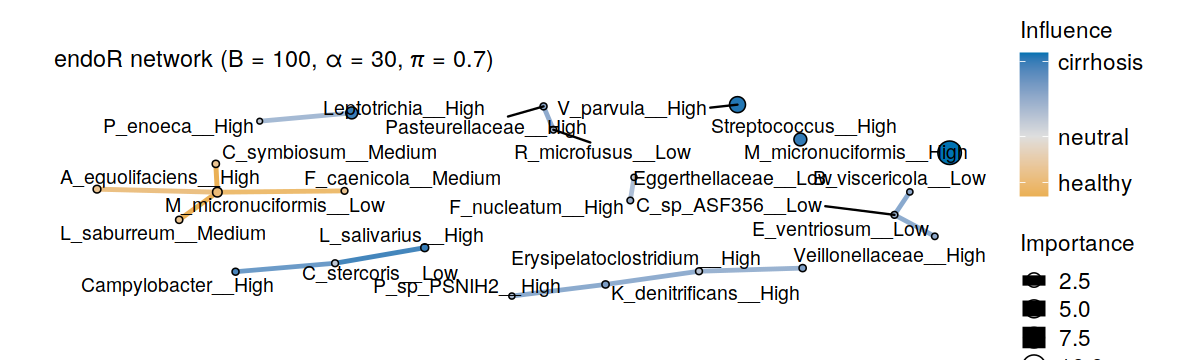

In [74]:
options(repr.plot.width=10, repr.plot.height=3)
net25

## aggregated features

In [75]:
# from the main text and supplementary table 4:
# order ignored
# Strains: species used, if the species was not detected in data, then the genus is used
qinH <- c('g_Bacteroides', 'g_Alistipes', 'g_Clostridium', 'g_Dialister ', 'g_Eggerthella', 'g_Eubacterium'
          , 'g_Oscillibacter', 'g_Parabacteroides', 'g_Subdoligranulum', 'f_Lachnospiraceae', 'f_Porphyromonadaceae'
          , 'f_Ruminococcaceae', 's_Alistipes_indistinctus', 's_Bacteroides_clarus', 's_Bacteroides_uniformis'
          , 's_Bilophila_wadsworthia', 's_Coprococcus_comes', 's_Faecalibacterium_prausnitzii')

qinC <- c('g_Veillonella', 'g_Streptococcus', 'g_Clostridium', 'g_Prevotella','g_Lactobacillus', 'g_Aggregatibacter'
          , 'g_Campylobacter', 'g_Haemophilus', 's_Bifidobacterium_dentium', 's_Clostridium_perfringens'
          , 's_Clostridium_symbiosum', 's_Fusobacterium_nucleatum', 's_Lactobacillus_fermentum'
          , 's_Lactobacillus_mucosae', 's_Lactobacillus_salivarius', 's_Megasphaera_micronuciformis'
          , 's_Prevotella_buccae', 's_Ruminococcus_gnavus', 's_Streptococcus_anginosus', 's_Streptococcus_oralis'
          , 's_Streptococcus_parasanguinis', 's_Streptococcus_salivarius', 's_Veillonella_parvula' )

In [76]:
relH <- list()
for (f in qinH){
    i <- which(colnames(tax_names) == str_extract(f, pattern = '^[:lower:]'))
    tmp <- unique(unlist(tax_names[which(tax_names[,i]==f), 5:7]))
    
    if (str_extract(f, pattern = '^[:lower:]') == 's'){
        tmp <- unique(c(tmp, unlist(tax_names[which(tax_names[,6]==tmp[2]), 5:7])))
    }
    
    relH[[f]] <- tmp
}

relC <- list()
for (f in qinC){
    i <- which(colnames(tax_names) == str_extract(f, pattern = '^[:lower:]'))
    tmp <- unique(unlist(tax_names[which(tax_names[,i]==f), 5:7]))
    
    if (str_extract(f, pattern = '^[:lower:]') == 's'){
        tmp <- unique(c(tmp, unlist(tax_names[which(tax_names[,6]==tmp[2]), 5:7])))
    }
    relC[[f]] <- tmp
}

In [77]:
featureImportance <- function(nodes){
    featImp <- copy(nodes)
    featImp$Feature <- str_replace(nodes$Feature, pattern = '\\_{2}.*', replacement = '')
    featImp <- group_by(featImp, Feature) %>% summarise(importance = sum(importance)) %>% arrange(-importance)
    return(featImp)
}

In [78]:
agg_imp <- featureImportance(pc$nodes)
agg_imp$Feature <- factor(agg_imp$Feature, levels = agg_imp$Feature[order(agg_imp$importance)])

`summarise()` ungrouping output (override with `.groups` argument)



In [79]:
agg_imp$inQin <- ifelse(agg_imp$Feature %in% c(qinH, qinC), 'yes'
                       , ifelse(agg_imp$Feature %in% c(unlist(relH), unlist(relC)), 'a related taxa was'
                                , 'no'))
agg_imp$inQin <- factor(agg_imp$inQin, levels = c('yes', 'a related taxa was', 'no'))

In [80]:
feat_agg <- ggplot(agg_imp, aes(x = Feature, y = importance)) + 
#geom_col(fill = 'lightgray', width = .1) + 
geom_point(aes(fill = inQin), size = 3, shape = 21) + coord_flip() + 
theme_classic() + 

theme(panel.grid.major.y = element_line(colour = "grey", size = .2)
      ,axis.text.x = element_text(size = rel(1.4))
      ,axis.text.y = element_text(size = rel(1.4))
      ,legend.text = element_text(size = rel(1.2)), legend.title = element_text(size = rel(1.2))
     , legend.position = 'left'
     #,legend.margin = unit(c(0,200,0,-100), 'pt')
     ) + 

labs(x = '', y = 'Importance', title = 'Aggregated importance')+
scale_fill_manual(values = c('chocolate2', 'goldenrod1', 'white'), name = 'Detected in Qin et al., 2014:'
                 , guide = guide_legend(ncol = 1, byrow = T, title.vjust = 0.5, title.position="top"))

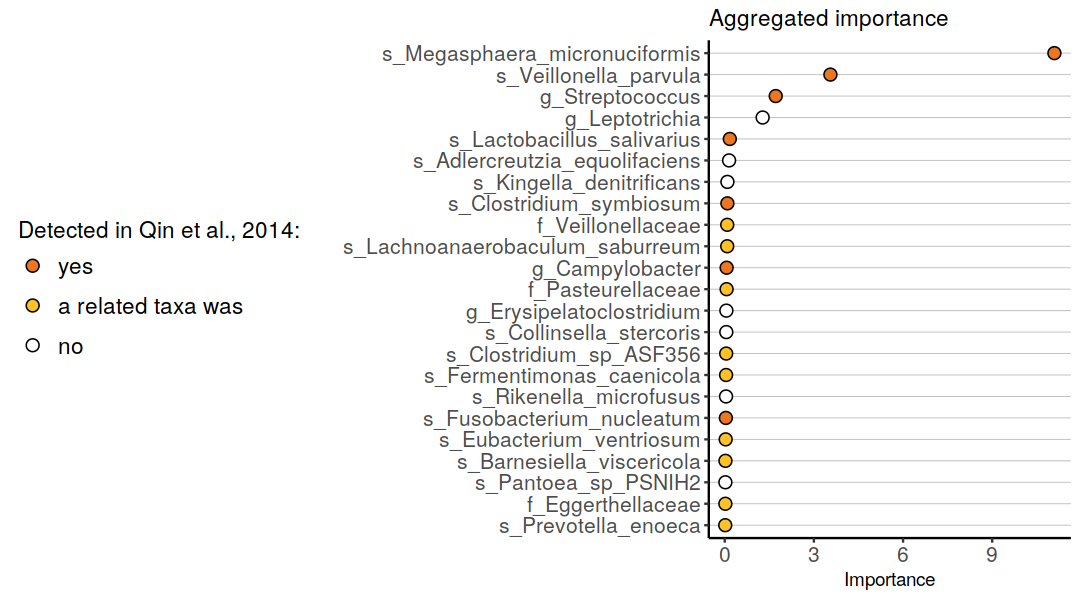

In [81]:
options(repr.plot.width=9, repr.plot.height=5)
feat_agg

## features

In [82]:
agg_imp$Feature_short <- agg_imp$Feature %>% str_replace(pattern = '(?<=s\\_[:upper:])[:lower:]+(?=\\_)', replacement = '') %>%
                str_replace(pattern = '^[:lower:]\\_', replacement = '')

In [83]:
tmp <- pc$nodes %>% select(var, influence)
tmp$level <- str_extract(tmp$var, pattern = '(?<=\\_{2}).*')
tmp$Feature_short <- str_extract(tmp$var, pattern = '.*(?=\\_{2})')
tmp <- left_join(tmp, select(agg_imp, Feature_short, Feature, importance), by = 'Feature_short')

In [84]:
tmp$Feature <- factor(tmp$Feature, levels = agg_imp$Feature[order(agg_imp$importance)])

In [85]:
tmp$level <- factor(tmp$level, levels = c('Low', 'Medium', 'High', 'male'))

In [86]:
level_inf <- ggplot(tmp, aes(x = level, Feature, fill= influence)) + geom_tile(color = 'white')+
theme_classic()+
theme(axis.text.x = element_text(size = rel(1.4))
      ,axis.text.y = element_blank()
      ,legend.text = element_text(size = rel(1.2))
      , legend.title=element_text(size=rel(1.2), vjust = .85)
      ) + 

labs(x = 'Level', y = '', title = 'Influence per level') +

scale_fill_gradient2(low = "#E69F00", mid = "grey87", high ="#0072B2", midpoint = 0, 
    , lim = lims,breaks = c(-0.25, 0, 0.4), labels = c('healthy', 'neutral', 'cirrhosis'), name = 'Influence')

## Assemblage

In [87]:
feats <- ggarrange(feat_agg, level_inf, ncol = 2, nrow = 1, labels = c('A', NULL), widths = c(1, .5))

In [88]:
r2 <- ggarrange(al_plot, net25, ncol = 2, nrow = 1, widths = c(0.25,0.75), labels = c('B', 'C'))

In [89]:
qin_plot <- ggarrange(feats, r2, ncol = 1, nrow = 2, heights = c(0.6, 0.4))

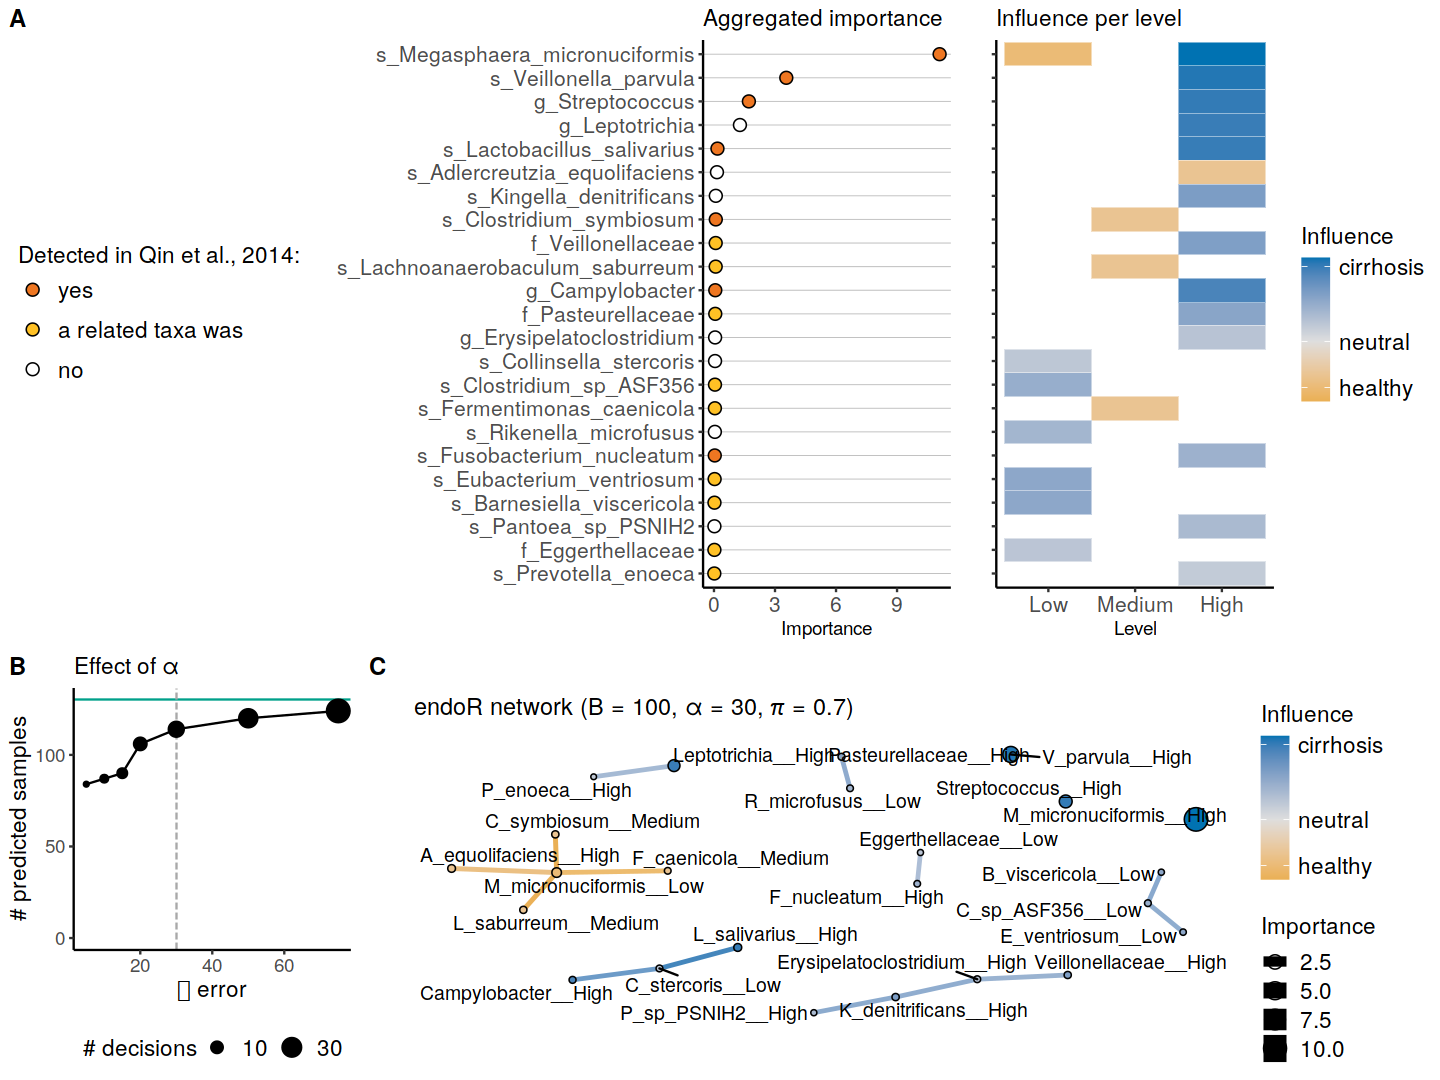

In [90]:
options(repr.plot.width=12, repr.plot.height=9)
qin_plot

# Save misc

In [101]:
saveRDS(agg_imp, '../tmp/agg_imp.RDS')